In [1]:
import sys
from glob import glob
import numpy as np



# Replace this with the path to the repository
# data_path = "/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Species/Staphylococcus hominis"
# data_path = "/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Species/Mycoplasmoides pneumoniae"
# data_path = "/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Family-Cross-Species/Salmonella-diarizonae"
# data_path = "/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Family/Aeromonadaceae"
data_path = "/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella"
# data_path = "/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Psychrobacter"
# data_path = "/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Pectobacterium"
# data_path = "/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Weissella"
# data_path = "/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Xylella"
# data_path = "/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Family-Cross-Genus/Brenneria"
# data_path = "/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Family-Cross-Genus/Edwardsiella"
# data_path = "/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Family-Cross-Genus/Kluyvera"
# data_path = "/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Family-Cross-Genus/Phytobacter"
# data_path = "/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Family-Cross-Genus/Escherichia"
sys.path.append(data_path)
sys.path.append("/home/bensonlzl/Desktop/UROP/GIS-2024/coding/ETFMH/")

In [2]:
from db_sketching.genome_selection import GenomeFiltering
from db_sketching.kmer_set import KMerSet, FracMinHash


def cond(kmer_hash):
    hash = (976369 * kmer_hash + 1982627) % 10000
    if hash < 100:
        return True
    else:
        return False

kmer_set = FracMinHash(cond, 12, True)
gf = GenomeFiltering(kmer_set)

In [3]:
print(glob(data_path+"/*.fna"))
genome_count = len(glob(data_path+"/*.fna"))
print(genome_count)

['/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/64.fna', '/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/32.fna', '/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/99.fna', '/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/43.fna', '/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/7.fna', '/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/98.fna', '/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/58.fna', '/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/90.fna', '/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/14.fna', '/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/41.fna', '/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/67.fna', '/home/bensonlzl/Desk

In [4]:


for f in glob(data_path+"/*.fna"):
    gf.insert_genome(f)
    print(f)

/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/64.fna
/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/32.fna
/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/99.fna
/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/43.fna
/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/7.fna
/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/98.fna
/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/58.fna
/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/90.fna
/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/14.fna
/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/41.fna
/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/Single-Genus/Salmonella/67.fna
/home/bensonlzl/Desktop/UROP/GIS-2024/coding/data_temp/

In [5]:

genome_list = list(gf.genome_dict.keys())
distance_matrix = np.zeros((len(genome_list), len(genome_list)))
for i in range(len(genome_list)):
    for j in range(i+1, len(genome_list)):
        distance = gf.genome_dict[genome_list[i]].resemblence(gf.genome_dict[genome_list[j]])
        distance_matrix[i][j] = distance_matrix[j][i] = 1 - distance

<Axes: >

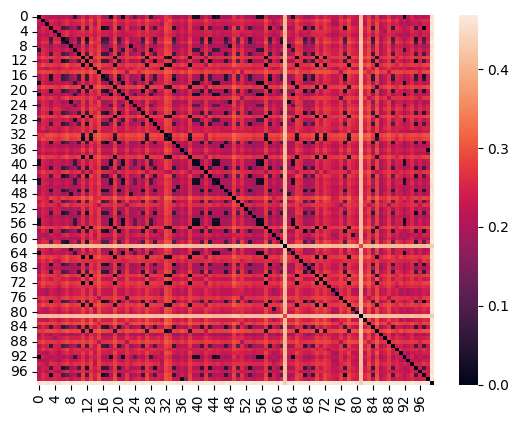

In [6]:
import seaborn

seaborn.heatmap(distance_matrix)

In [7]:
hc = gf.hierarchical_clustering(genome_list, distance_matrix, 0.15)
hc

[[1],
 [2],
 [4],
 [5],
 [15],
 [25],
 [30],
 [14, 31],
 [37],
 [42],
 [35, 46],
 [49],
 [51],
 [52],
 [54],
 [60],
 [62],
 [8, 23, 48, 63],
 [66],
 [68],
 [71],
 [73],
 [74],
 [75],
 [22, 76],
 [59, 79],
 [80],
 [81],
 [82],
 [83],
 [11, 13, 19, 27, 32, 33, 38, 57, 65, 70, 72, 78, 85],
 [86],
 [87],
 [88],
 [90],
 [91],
 [0, 9, 18, 21, 24, 28, 39, 40, 44, 45, 55, 56, 64, 92],
 [93],
 [94],
 [96],
 [3,
  6,
  7,
  10,
  12,
  16,
  17,
  20,
  26,
  29,
  34,
  41,
  43,
  47,
  50,
  53,
  58,
  61,
  67,
  69,
  77,
  84,
  89,
  95,
  97],
 [36, 98],
 [99]]

In [8]:
# Naive way of selecting signature
from collections import Counter

naive_counter = Counter()

for f in genome_list:
    naive_counter.update(list(gf.genome_dict[f].set))


<Axes: ylabel='Count'>

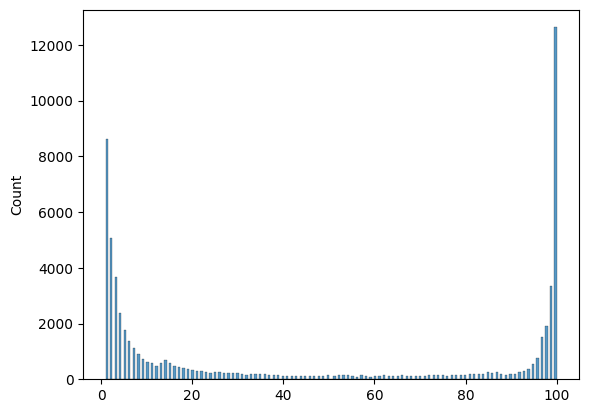

In [9]:
seaborn.histplot([i for i in list(naive_counter.values()) if i >= 0], bins=200)


In [10]:
# After hierarchical clustering
import random
hc_counter = Counter()

for j in hc:
    sampled_genome = random.sample(j, 1)
    print(sampled_genome)
    hc_counter.update(list(gf.genome_dict[genome_list[sampled_genome[0]]].set))

[1]
[2]
[4]
[5]
[15]
[25]
[30]
[14]
[37]
[42]
[46]
[49]
[51]
[52]
[54]
[60]
[62]
[8]
[66]
[68]
[71]
[73]
[74]
[75]
[22]
[59]
[80]
[81]
[82]
[83]
[32]
[86]
[87]
[88]
[90]
[91]
[24]
[93]
[94]
[96]
[20]
[98]
[99]


In [11]:
hc_counts = [i for i in list(hc_counter.values()) if i >= 0]
m1_hc_counts = [x-1 for x in hc_counts]
n = len(hc) - 1

<Axes: ylabel='Count'>

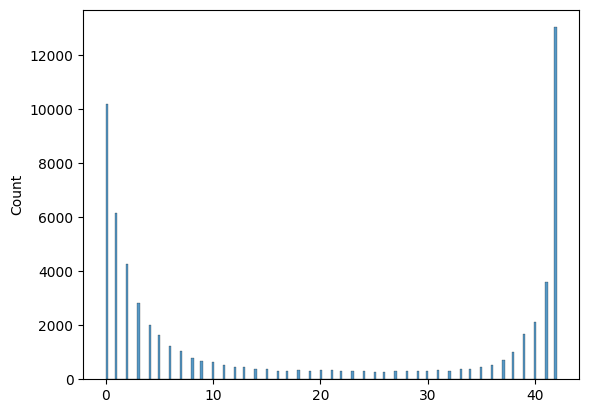

In [12]:
# seaborn.histplot(hc_counts, bins=200)
seaborn.histplot(m1_hc_counts, bins=200)

In [13]:
from scipy.special import gammaln

def nb_pmf(k, mu, theta):
    term1 = np.exp(gammaln(k + theta) - gammaln(k + 1) - gammaln(theta))
    term2 = (theta / (theta + mu)) ** theta
    term3 = (mu / (theta + mu)) ** k
    return term1 * term2 * term3

def zinb_pmf(k, mu, theta, p):
    nb_pmf_val = nb_pmf(k,mu,theta)

    if k == 0:
        return p + (1 - p) * nb_pmf_val
    else:
        return (1 - p) * nb_pmf_val
    
def combined_zinb_pmf(k, n, *args):
    mu1, theta1, p1, mu2, theta2, p2, w1 = args
    w2 = 1 - w1
    pmf1 = w1 * zinb_pmf(k, mu1, theta1, p1)
    pmf2 = w2 * zinb_pmf(n-k, mu2, theta2, p2) # reflected across the multiplicities
    return pmf1 + pmf2

def combined_nb_pmf(k, n, *args):
    mu1, theta1, mu2, theta2, w1 = args
    w2 = 1 - w1
    pmf1 = w1 * nb_pmf(k,mu1,theta1)
    pmf2 = w2 * nb_pmf(n-k,mu2,theta2)
    return pmf1 + pmf2
    

# Define the negative log-likelihood function
def neg_log_likelihood_zinb_pmf(params, data):
    # mu1, theta1, p1, mu2, theta2, p2, w1 = params
    likelihoods = [combined_zinb_pmf(k, n, *params) for k in data]
    return -np.sum(np.log(likelihoods))

# Define the negative log-likelihood function
def neg_log_likelihood_nb_pmf(params, data):
    # mu1, theta1, mu2, theta2, w1 = params
    likelihoods = [combined_nb_pmf(k, n, *params) for k in data]
    return -np.sum(np.log(likelihoods))

In [14]:
from scipy.optimize import minimize



# Initial parameter guesses
zinb_initial_params = [1, 1, 0.3, 1, 1, 0.4, 0.5]
nb_initial_params = [1, 1, 1, 1, 0.5]

# Set parameter bounds
zinb_bounds = [(0.1, None), (0.1, None), (0, 1), (0.1, None), (0.1, None), (0, 1), (0, 1)]
nb_bounds = [(0.1, None), (0.1, None), (0.1, None), (0.1, None), (0, 1)]

# Perform the optimization
zinb_result = minimize(neg_log_likelihood_zinb_pmf, zinb_initial_params, args=(m1_hc_counts,), method='L-BFGS-B', bounds=zinb_bounds)
nb_result = minimize(neg_log_likelihood_nb_pmf, nb_initial_params, args=(m1_hc_counts,), method='L-BFGS-B', bounds=nb_bounds)
zinb_fitted_params = zinb_result.x
nb_fitted_params = nb_result.x

print(f"Mixed ZINB Fitted parameters: {zinb_fitted_params}")
print(f"Mixed NB Fitted parameters: {nb_fitted_params}")


Mixed ZINB Fitted parameters: [4.20649936 0.56910418 0.         3.28778076 0.28918504 0.
 0.56982013]
Mixed NB Fitted parameters: [4.20636436 0.56909663 3.2874833  0.28917867 0.56982529]


4.206499363312259 0.5691041837424917 0.0
3.287780762298347 0.2891850444533757 0.0
0.5698201337405933
Salmonella


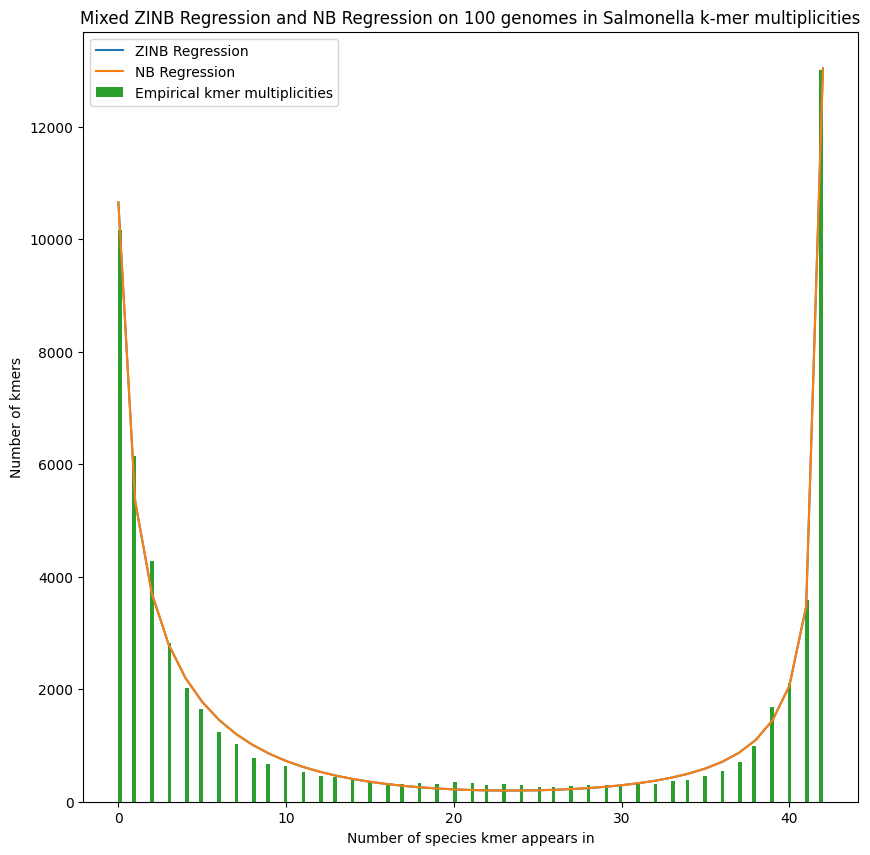

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
mu1, theta1, p1, mu2, theta2, p2, w1 = zinb_fitted_params
print(mu1,theta1,p1)
print(mu2,theta2,p2)
print(w1)

target_data = data_path.split('/')[-1]
print(target_data)
ax.set_title(f"Mixed ZINB Regression and NB Regression on {genome_count} genomes in {target_data} k-mer multiplicities")
ax.set_xlabel("Number of species kmer appears in")
ax.set_ylabel("Number of kmers")
ax.plot(list(range(0,n+1)), [combined_zinb_pmf(k, n, *zinb_fitted_params)*len(m1_hc_counts) for k in range(0,n+1)], label="ZINB Regression")
ax.plot(list(range(0,n+1)), [combined_nb_pmf(k, n, *nb_fitted_params)*len(m1_hc_counts) for k in range(0,n+1)], label="NB Regression")
ax.hist(m1_hc_counts, bins=200, label="Empirical kmer multiplicities")
ax.legend()

In [16]:
print(sum([combined_zinb_pmf(k, n, *zinb_fitted_params) for k in range(0,n+1)]))
print(sum([zinb_pmf(k, mu1, theta1, p1) for k in range(0,n+1)]))

0.9979649391404746
0.9987347452304963
